In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import random
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# constants for the traffic grid (will later be used for coloring the grid)
road_cell = -1
city_cell = -2
green_light = -3
red_light = -4

class Road: 
    """
    Stores data about the roads in the simulation
    ----------------------------------
    idx (int): 
        location of the road on the grid
    flow (int): 
        flow of traffic (up-down and left-right = 1; down-up and right-left = -1)
    position (str): 
        position of the street (horizontal or vertical)
    """

    def __init__(self, idx, flow, position):
        self.idx = idx
        self.flow = flow
        self.position = position


class TrafficLight: 
    """
    Stores data of every traffic light in the simulation.
    ----------------------------------
    x_coord (int):
        location of the traffic light on the x-axis
    y_coord (int):
        location of the traffic light on the y-axis
    red_time (int): 
        duration of red light
    green_time (int): 
        duration of green light
    color (str):
        current color of the traffic light
    """

    def __init__(self, x_coord, y_coord, red_time = 10, green_time = 10):
        self.x_coord = x_coord
        self.y_coord = y_coord
        self.red_time = red_time
        self.green_time = green_time
        self.color = 'red'

In [3]:
class Simulation:
    """
    Implements the traffic simulation.
    """
    def __init__(self, idx1, idx2, strategy, car_density, grid_size=50, 
                 prob_slow=0.2, max_speed=5, prob_turn = 0.3):
        """
        Initializes basic properties of the traffic simulation. Cars are distributed randomly
        along the road and start with random velocities.
        ----------------------------------
        idx1 (int):
            coordinate of the first road
        idx1 (int):
            coordinate of the second road
        strategy (arr):
            order which the traffic lights follow
        car_density (float):
            fraction of cells that have a car on them
        grid_size (int):
            size of the grid
        prob_slow (float):
            probability that a car will randomly slow down by 1 during the update step
        max_speed (int):
            Maximum speed any car can have
        prob_turn(float):
            probability of a car turning
        """
        self.idx1 = idx1
        self.idx2 = idx2
        self.strategy = strategy 
        self.car_density = car_density
        self.grid_size = grid_size
        self.prob_slow = prob_slow
        self.max_speed = max_speed
        self.prob_turn = prob_turn
        self.time = 0 # starting time of the simulation

        self.average_traffic_flow = []
        self.car_count = [] # total count of cars
        self.cars_per_road = [[], [], [], []] # number of cars on every road
        self.cur_light = None # current traffic light in use
        self.traffic_light_time = 0 # starting time of the traffic light work

    def start_lights(self):
        """
        Starts the traffic lights by assigning them a red color.
        """
        for group in self.strategy:
            for light in group:
                light.color = 'red'

    def initialize(self):
        """
        Initializes the traffic simulation.
        """
        # create a grid
        self.grid = np.full((self.grid_size, self.grid_size), 
                            city_cell, dtype=int)
        # place roads on the grid
        road1 = Road(self.idx1, 1, 'horizontal') # left to right 
        road2 = Road(self.idx2, -1, 'horizontal') # right to left 
        road3 = Road(self.idx1, -1, 'vertical') # bottom to top
        road4 = Road(self.idx2, 1, 'vertical') # top to bottom
        self.roads = [road1, road2, road3, road4]

        # assign a specific color to all road cells
        self.grid[road1.idx, :] = road_cell
        self.grid[road2.idx, :] = road_cell
        self.grid[:, road3.idx] = road_cell
        self.grid[:, road4.idx] = road_cell

        # add the traffic lights to the grid and start them all at red
        self.grid[16,15] = red_light 
        self.grid[17,16] = red_light
        self.grid[16,32] = red_light
        self.grid[15,33] = red_light
        self.grid[33,17] = red_light 
        self.grid[34,16] = red_light 
        self.grid[33,34] = red_light 
        self.grid[32,33] = red_light
      
        # add cars
        road_idxs = np.where(self.grid == road_cell)
        self.road_cell_count = len(road_idxs[0])
        road_idxs = list(zip(road_idxs[0], road_idxs[1]))
      
        # choose random locations to place cars
        car_indexes = random.sample(road_idxs,
                    k=int(round(self.car_density * len(road_idxs))))
        
        # randomly assign initial speed to every car
        for i, j in car_indexes:
            self.grid[i,j] = np.random.randint(0, self.max_speed)
        self.start_lights()

    def light_control(self):
        """
        Switches the traffic lights based on the time and set of rules.
        """
        
        # every new set of traffic lights
        if self.cur_light == None: 
            # retrieve a set of traffic lights with their locations
            self.cur_light = self.strategy.pop(0)
            # add the same set to the back of an array because it will be reused later
            self.strategy.append(self.cur_light)
            # increase the traffic light time by 1 so that it matches simulation time below
            self.traffic_light_time += 1
            #print(f"Traffic time: {self.traffic_light_time}, simulation time: {self.time}")

        if self.cur_light[0].color == 'red':
            # if the timer of red light is up
            if self.traffic_light_time == self.time:
                # change all lights in the set to green
                for light in self.cur_light:
                    self.grid[light.x_coord, light.y_coord] = green_light
                    light.color = 'green'

                # set a timer of green light
                self.traffic_light_time = self.time + light.green_time
                #print(f"went from red to green at {self.time}. Total time is {self.traffic_light_time}")

        elif self.cur_light[0].color == 'green':
            # if the timer of green light is up
            if self.traffic_light_time == self.time:
                # change all lights in the set to red
                for light in self.cur_light:
                    self.grid[light.x_coord, light.y_coord] = red_light
                    light.color = 'red'
                # mark the set of traffic lights as used (necessary for retrieval later)
                self.cur_light = None
                #print(f"went from green to red at {self.time}. Total time is {self.traffic_light_time}")
        
    def update(self):
        """
        Moves one step forward in the traffic simulation.
        """
        # start the traffic lights
        self.light_control()

        # check every road
        for rd_idx, road in enumerate(self.roads):
            # check road position on the grid
            if road.position == 'horizontal':
                if road.flow == -1:
                    # flip the indices if the road goes in the opposite direction
                    # so that the same rules apply during update (will be flipped back later)
                    self.grid[road.idx, :] = np.flip(self.grid[road.idx, :])

                # find the position of all cars on the road and count the number of cars
                car_idxs = np.where(self.grid[road.idx, :] >= 0)[0]
                self.cars_per_road[rd_idx].append(len(car_idxs))
 
                for location in car_idxs:
                    # apply speed update rules
                    distance = 1
                    while self.grid[road.idx, (location + distance) % 
                                    self.grid_size] in [road_cell, green_light]:
                        distance += 1
                  
                    # increase the speed by 1 if it hasn't reached its max
                    if self.grid[road.idx, location] < self.max_speed:
                        self.grid[road.idx, location] += 1

                    # decrease the speed if there is a car in front
                    if self.grid[road.idx, location] >= distance:
                        self.grid[road.idx, location] = distance - 1

                    # randomly decrease the speed
                    if ((self.grid[road.idx, location] > 0) and
                        (np.random.uniform() < self.prob_slow)):
                        self.grid[road.idx, location] -= 1

                    # determine where the car should move depending 
                    # on the speed update rules
                    dist_to_move = self.grid[road.idx, location]

                    if dist_to_move > 0:
                        # determine new car position
                        new_pos = (location + dist_to_move) % self.grid_size

                        # make sure new position doesn't correspond to the position
                        # of the traffic light; otherwise keep moving the car forward
                        if self.grid[new_pos, road.idx] == green_light:
                            new_pos = (new_pos+1)%self.grid_size
                        
                        # change the cell where the car should be placed
                        self.grid[road.idx, new_pos] = dist_to_move
                        # change the cell back to the road one (there is no car here anymore)
                        self.grid[road.idx, location] = road_cell 

                # flip the roads back if the flow is opposite
                if road.flow == -1:
                    self.grid[road.idx, :] = np.flip(self.grid[road.idx, :])
        
            # check road position on the grid
            if road.position == 'vertical':
          
                # flip the indices if the road goes in the opposite direction
                # so that the same rules apply during update (will be flipped back later)
                if road.flow == -1: 
                    self.grid[:, road.idx] = np.flip(self.grid[:, road.idx])

                # find the position of all cars on the road and count the number of cars
                car_idxs = np.where(self.grid[:, road.idx] >= 0)[0]
                self.cars_per_road[rd_idx].append(len(car_idxs))

                # apply speed update rules
                for location in car_idxs:
                    # measure the distance to the next car
                    distance = 1
                    while self.grid[(location + distance) % 
                        self.grid_size, road.idx] in [green_light, road_cell]:
                        distance += 1

                    # increase the speed by 1 if it hasn't reached its max
                    if self.grid[location, road.idx] < self.max_speed:
                        self.grid[location, road.idx] += 1

                    # decrease the speed if there is a car in front
                    if self.grid[location, road.idx] >= distance:
                        self.grid[location, road.idx] = distance - 1

                    # randomly decrease the speed
                    if ((self.grid[location, road.idx] > 0) and
                        (np.random.uniform() < self.prob_slow)):
                        self.grid[location, road.idx] -= 1

                    # determine where the car should move depending 
                    # on the speed update rules
                    dist_to_move = self.grid[location, road.idx]

                    if dist_to_move > 0:
                        # determine new car position
                        new_pos = (location + dist_to_move) % self.grid_size

                        # make sure new position doesn't correspond to the position
                        # of the traffic light; otherwise keep moving the car forward
                        if self.grid[new_pos, road.idx] == green_light:
                            new_pos = (new_pos+1)%self.grid_size
                        
                        # change the cell where the car should be placed
                        self.grid[new_pos, road.idx] = dist_to_move
                        # change the cell back to the road one (there is no car here anymore)
                        self.grid[location, road.idx] = road_cell 

                # flip the roads back if the flow is opposite
                if road.flow == -1:
                    self.grid[:, road.idx] = np.flip(self.grid[:, road.idx])

        # increase the simulation time counter
        self.time += 1

        # calculate average traffic flow
        car_idxs = np.where(self.grid >= 0)
        car_speeds = self.grid[car_idxs]
        self.average_traffic_flow.append(sum(car_speeds) / self.road_cell_count)
        self.car_count.append(len(car_idxs[0]))
        

    def draw(self):
        """
        Displays the current state of the traffic simulation.
        """

        # initialize the colors of the grid based on the values
        # mentioned in the beginning (red=-4, green=-3, etc.)
        self.colors = ['red', 'green', 'black', 'grey']
        # add a color for displaying cars and their movement
        self.colors.extend(['white' for _ in range(np.max(self.grid)+1)])
        self.cmap = ListedColormap(self.colors)
        # display the grid
        plt.imshow(self.grid, cmap=self.cmap)

In [4]:
# initialize the positions of all traffic lights (8 in this case)
# top left intersection
tr_light1 = TrafficLight(16, 15) 
tr_light2 = TrafficLight(17, 16) 
# top right intersection 
tr_light3 = TrafficLight(16, 32) 
tr_light4 = TrafficLight(15, 33) 
# bottom left intersection
tr_light5 = TrafficLight(33, 17)
tr_light6 = TrafficLight(34, 16)
# bottom right intersection
tr_light7 = TrafficLight(33, 34) 
tr_light8 = TrafficLight(32, 33) 

# strategy 1 (lights on the same flow + position)
Strategy1 = [(tr_light1,tr_light3), (tr_light2,tr_light4),
                (tr_light5,tr_light7), (tr_light6,tr_light8)]

# strategy 2 (lights on the same position: all horizontal/vertical)
Strategy2 = [(tr_light1,tr_light3,tr_light5,tr_light7), 
                (tr_light2,tr_light4,tr_light6,tr_light8)]

I would like to acknowledge the help I received from discussions of the best assignment approaches with Isabel Brunkan (M23) (specifically, animation display and calculation of confidence intervals for average and maximum traffic flow).

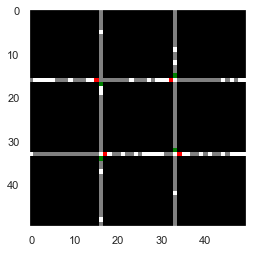

In [5]:
# initialize a proper set of figures
fig, ax = plt.subplots()
# run the simulation with applying the second strategy
sim = Simulation(16, 33, Strategy2, 0.3)
# initialize a simulation
sim.initialize()
# display the current simulation state (step 0)
sim.draw()

map_view = sim.grid
ax.grid(False)
# show the map view
im = ax.imshow(map_view, cmap = sim.cmap)

simulate_time = 100

def updatefig(s):
    """
    Updates the simulation and turns the resulting image into an array
    """
    sim.update()
    fig = sim.grid
    im.set_array(fig)
    return [im]

ani = animation.FuncAnimation(fig, updatefig, frames=simulate_time, interval=1000)
HTML(ani.to_html5_video())

### Traffic Flow with Different Traffic Light Strategies and Different Car Densities

In [6]:
# Define a function to run an empirical analysis simulation to reuse for less code repetition

def sim_test(density, iters, strategy, slow_prob = None):
    """
    Tests different parameters of the simulation.
    ----------------------------------
    density (float):
        car density
    iters (int):
        number of iterations the simulation is run for
    strategy (arr):
        traffic light strategy
    slow_prob (float):
        probability of random slowdown
    """
    # mean and max traffic flow values from every simulation iteration
    sim_mean = []
    sim_max = []

    # default slowdown probability
    if slow_prob == None:
        slow_prob = 0.2
    
    # run simulation for a pre-defined number of iterations
    for step in range(iters):
        sim = Simulation(16, 33, strategy, car_density=density, prob_slow=slow_prob)
        sim.initialize()
        # update the state of the simulation 1000 times
        for _ in range(1000):
            sim.update()
        # retrieve the values of interest
        sim_mean.append(np.mean(sim.average_traffic_flow))
        sim_max.append(np.max(sim.average_traffic_flow))
    
    return sim_mean, sim_max 

In [7]:
car_densities = np.arange(0, 1, 0.1)
trials = 50

# data structures to store results from running 
# the simulation with the first strategy
avg_final = np.zeros(len(car_densities))
avg_CI = np.zeros(len(car_densities))
max_final = np.zeros(len(car_densities))
max_CI = np.zeros(len(car_densities))

# data structures to store results from running 
# the simulation with the second strategy
avg_final2 = np.zeros(len(car_densities))
avg_CI2 = np.zeros(len(car_densities))
max_final2 = np.zeros(len(car_densities))
max_CI2 = np.zeros(len(car_densities))

# iterate through all car densities
for d_idx, car_d in enumerate(car_densities):
    
    # collect results from applying the first strategy
    sim_mean, sim_max = sim_test(car_d, trials, Strategy1)
    avg_final[d_idx] = np.mean(sim_mean)
    avg_CI[d_idx] = 1.96*(np.std(sim_mean)/np.sqrt(trials))
    max_final[d_idx] = np.mean(sim_max)
    max_CI[d_idx] = 1.96*(np.std(sim_max)/np.sqrt(trials))

    # collect results from applying the second strategy
    sim_mean, sim_max = sim_test(car_d, trials, Strategy2)
    avg_final2[d_idx] = np.mean(sim_mean)
    avg_CI2[d_idx] = 1.96*(np.std(sim_mean)/np.sqrt(trials))
    max_final2[d_idx] = np.mean(sim_max)
    max_CI2[d_idx] = 1.96*(np.std(sim_max)/np.sqrt(trials))
    print(f'Tests for car density = {round(car_d,1)} are completed.')

Tests for car density = 0.0 are completed.
Tests for car density = 0.1 are completed.
Tests for car density = 0.2 are completed.
Tests for car density = 0.3 are completed.
Tests for car density = 0.4 are completed.
Tests for car density = 0.5 are completed.
Tests for car density = 0.6 are completed.
Tests for car density = 0.7 are completed.
Tests for car density = 0.8 are completed.
Tests for car density = 0.9 are completed.


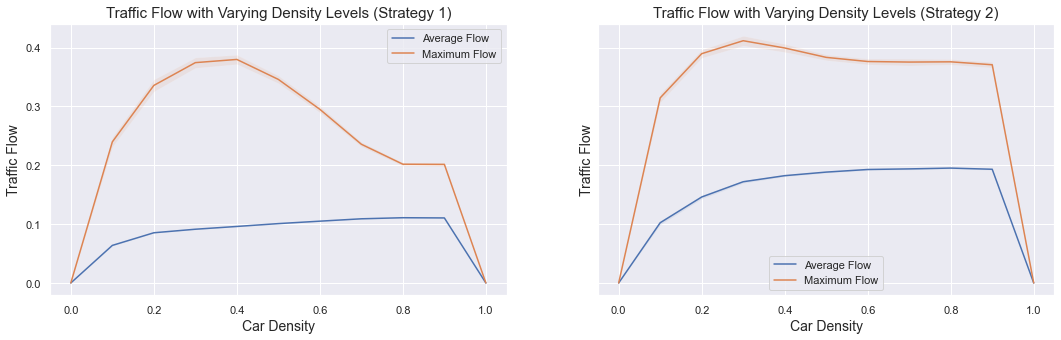

In [8]:
fig, axs = plt.subplots(1,2, figsize=(18,5),sharex=True,sharey=True)
# My simulation seems to get stuck for a long time at car_density=1 
# (mostly due to the system being overloaded). Thus, I decided to add
# the values myself since we know that traffic flow is be 0 because
# no cars are moving. Same applies to confidence intervals.
car_densities = np.append(car_densities, 1)
avg_final = np.append(avg_final, 0)
max_final = np.append(max_final, 0)
avg_CI = np.append(avg_CI, 0)
max_CI= np.append(max_CI, 0)
avg_final2 = np.append(avg_final2, 0)
max_final2 = np.append(max_final2, 0)
avg_CI2 = np.append(avg_CI2, 0)
max_CI2 = np.append(max_CI2, 0)
# plot the resulting metrics
axs[0].plot(car_densities, avg_final, label="Average Flow")
axs[0].plot(car_densities, max_final, label="Maximum Flow")
axs[0].fill_between(car_densities, (avg_final-avg_CI), (avg_final+avg_CI), alpha=0.1)
axs[0].fill_between(car_densities, (max_final-max_CI), (max_final+max_CI), alpha=0.1)
axs[0].set_title('Traffic Flow with Varying Density Levels (Strategy 1)', size=15)
axs[0].set_ylabel('Traffic Flow', size=14)
axs[0].set_xlabel('Car Density', size=14)
axs[0].legend()

axs[1].plot(car_densities, avg_final2, label="Average Flow")
axs[1].plot(car_densities, max_final2, label="Maximum Flow")
axs[1].fill_between(car_densities, (avg_final2-avg_CI2), (avg_final2+avg_CI2), alpha=0.1)
axs[1].fill_between(car_densities, (max_final2-max_CI2), (max_final2+max_CI2), alpha=0.1)
axs[1].set_title('Traffic Flow with Varying Density Levels (Strategy 2)', size=15)
axs[1].set_ylabel('Traffic Flow', size=14)
axs[1].set_xlabel('Car Density', size=14)
axs[1].legend()

plt.show()

### Traffic Flow with Different Light Durations and Car Densities

In [9]:
def vary_light_duration(strategy, red_length, green_length):
    """
    Modifies traffic light duration in the existing strategy.
    ----------------------------------
    strategy (arr):
        traffic light strategy
    red_length(int):
        duration of the red light on all traffic lights within the strategy set
    green_length(int):    
        duration of the green light on all traffic lights within the strategy set
    """
    # iterate through every set in the strategy
    for el in strategy: 
        # iterate through every light in the set
        for light in el:
            # set the duration of red and green light
            light.green_time = green_length
            light.red_time = red_length
            light.color = 'red'
    return strategy

In [12]:
trials=50
traffic_light_duration = [5, 10, 15, 30, 45, 60]
car_densities = [0, 0.25, 0.5, 0.75]

# data structures to store results from running 
# the simulation with the second strategy
avg_traffic_flow = np.zeros((len(traffic_light_duration), len(car_densities)))
avg_GCI = np.zeros((len(traffic_light_duration), len(car_densities)))
max_traffic_flow = np.zeros((len(traffic_light_duration), len(car_densities)))
max_GCI = np.zeros((len(traffic_light_duration), len(car_densities)))

# iterate through all traffic light durations
for duration_idx, duration in enumerate(traffic_light_duration):
    # iterate through all car densities
    for density_idx, density in enumerate(car_densities):
        strategy_light = vary_light_duration(Strategy2, duration, duration)
        sim_mean, sim_max = sim_test(density, trials, strategy_light)
        # calculate necessary metrics
        avg_traffic_flow[duration_idx, density_idx] = np.mean(sim_mean)
        avg_GCI[duration_idx, density_idx] = 1.96*(np.std(sim_mean)/np.sqrt(trials))
        max_traffic_flow[duration_idx, density_idx] = np.mean(sim_max)
        max_GCI[duration_idx, density_idx] = 1.96*(np.std(sim_max)/np.sqrt(trials))
    print(f"Tests for traffic light duration = {duration} are completed.")

Tests for traffic light duration = 5 are completed.
Tests for traffic light duration = 10 are completed.
Tests for traffic light duration = 15 are completed.
Tests for traffic light duration = 30 are completed.
Tests for traffic light duration = 45 are completed.
Tests for traffic light duration = 60 are completed.


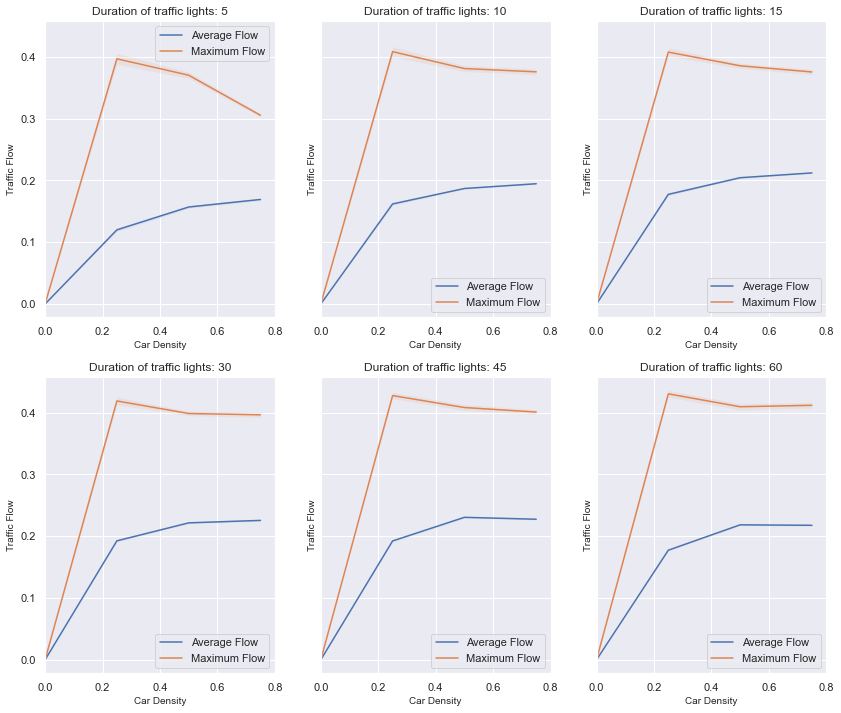

In [16]:
# plot the resulting values
fig,axs = plt.subplots(2,3,figsize=(14,12),sharey=True)
idx = 0
for i in range(2):
    for j in range(3):
        axs[i,j].plot(car_densities,avg_traffic_flow[idx,:], label ='Average Flow')
        axs[i,j].fill_between(car_densities, (avg_traffic_flow[idx,:]-avg_GCI[idx,:]),
                              (avg_traffic_flow[idx,:]+avg_GCI[idx,:]), alpha=0.1)
        axs[i,j].fill_between(car_densities, (max_traffic_flow[idx,:]-max_GCI[idx,:]),
                              (max_traffic_flow[idx,:]+max_GCI[idx,:]), alpha=0.1)
        axs[i,j].plot(car_densities,max_traffic_flow[idx,:], label= 'Maximum Flow')
        axs[i,j].set_xlim([0, 0.8])
        axs[i,j].set_title(f"Duration of traffic lights: {traffic_light_duration[idx]}", size=12)
        axs[i,j].set_ylabel("Traffic Flow", size=10)
        axs[i,j].set_xlabel("Car Density", size=10)
        axs[i,j].legend()
        idx+=1